# Predicting Major Power Outages

**Jiawei Yang, Zhixing Jiang**

## Summary of Findings

### Introduction
Based on the dataset of major power outages happened in the United State during recent years, our ultimate goal in this project is to predict if the duration of the power outage is `<= 1 day`, `<= 3 days but > 1 day`, and `above 3 days` given various characteristics that pertain to directly to the specific instance of power outage and indirectly to the area where the outage takes place.

We encode the variable `outage.duration` based on whether it is less than a day, more than a day but less than 3 days, or more than 3 days into a a new variable `duration.encoded`. We chose this new variable `duration.encoded` to be our response variable. We chose it since it categorize the length of duration of outages and give us a brief idea of the length of the outage duration

Since we attempt to predict a categorical outcome, we use classifier-based algorithm to build the model: we end up using decision tree classifier after comparing it to KNN classifier. We will use R-squared as our main metric to evaluate the performance of our model.

### Baseline Model
In the prediction process, we assume that the model is used to predict if the duration of the power outage is `<= 1 day`, `<= 3 days but > 1 day`, and `above 3 days` after the happening of that power outage. Therefore the following features from the original data set could not be used as input variables, since they are by natural unobserved at the point of outage happenings:
1. `outage.restoration.time`: this directly tells you the outage durtaion.
<br>
<br>
2. `customers.affected`: we assume this statistic is collected/estiamted at least some time after one outage happening.

We include the following features in the model:
1. `u.s._state`: the state in which the outage took place, originally recorded as categorical strings with 50+ levels. (One-hot encoded in the model)
<br>
<br>
2. `cause.category`: the description of cause of outage, originally recorded as categorical stirngs with 20+ levels. (One-hot encoded in the model) One may argue the cause or reason of the outage is not revealed immediately after the outage happening. (Since it may take time for the company to investigate) We are aware of such potential concerns, but decided to include this feature in the model assuming the company would know right away why an outage happens.

We use train-test split and cross validation to pick the model that maximize both in-sample and out-of-sample performance: specifically, we pick the best hyperparameter, max depth, of the prediction tree based on R-sqaured. The best hyperparameter we found for max_depth is 14. The accuracy of the train set is around 0.7043 while the one for test set is around 0.6653, which is not good because we get accuracy 0.6683 when we simply use max_depth 5 in our initial model. For the next step, we are planning to introduce more features into our final model to improve the performance

### Final Model
On top of the features present in the baseline model, we include the following three features in the final model, hoping to improve performance. The additional features are results of feature engineering based on both information recorded in the model and additional data we collected (during project 3). Feature engineering is done by `ColumnTransformer` classes we define.

We believe that extreme weather could hinder the process of restoring a power outage and therefore influence the duration of power outage. We further specify 'extreme weather' to be hot summer and cold winder by encoding the power outages with the following four features.

1. `hot_summer`: a binary encoding, `True` if the power outage took place both:
<br>
$\;\;\;\;\;\;$   in one of the months: June, July or August
<br>
$\;\;\;\;\;\;$   in a state where the average summer temperature is above 25 degree celsius.
<br>
2. `cold_winter`: a  binary encoding, `True` if the power outage took place both:
<br>
$\;\;\;\;\;\;$   in one of the months: December, January or February
<br>
$\;\;\;\;\;\;$   in a state where the average winter temperature is below 0 degree celsius.
<br>
3. `cause.category.detail`: the detail description of the cause in cateogory, orginally recorded as cartegorical strings with 50+ levels(One-hot encoded in the model). We are choosing this feature in the model also assuming the company would know right away because incidents like heavy wind or winter storm are easily spotted.
<br>
4. `outage.start.time`: In addition, we introduce another feature from the orginal dataset "outage.start.time". However, we believe that we cannot treat it as continuous, so we created a function to discretize the column. We split the day into four periods of time: Morning (5 am to 12 pm), Afternoon (12 pm to 5 pm), Evening (5 pm to 9 pm), and Night (9 pm to 4 am).

We discovered that to make the best prediction, we should choose the hyperparameter max_depth: 12, splitter: random. The accuracy of the train set is around 0.8145 while the one for test set is around 0.7042, which has a noticeable improvement by around 10 percent comparing to the test set performance of the baseline model. The difference in accuaracy between the train set and the test set is still significant that we cannot rule out the possibility of overfitting.

### Fairness Analysis
In our test data with the final model, we find that the model predicts the categorical duration of outage slightly more accurately for the outages that start before noon in the day, as compared to those that start after noon. We seek to use permutation test to answer the question of whether our model is unfair in that it predicts outages whose start time in the day is before 12:00 PM more accurately than those after 12:00 PM. (i.e. we binarize every observation with respect to its `outage.start.time` in the day with a threshold of 12)

Specifically, the following set of hypothesis is tested:<br>
 $H_0$: our model is fair, it predicts outages that start before 12:00 PM roughly as accurately as it predicts ones starting after 12:00PM in the day. <br>
 $H_a$: our model is not fair, it predicts outage that start before 12:00 PM better.
 
By comparing the predict result of `X2_test` and `y2_test`, we get accuracy of each prediction. We then shuffle the start time column to run a permutation test.

We use difference in signed difference in mean: Accuracy(A.M. outages) - Accuracy(P.M. outages) as our test statistic. And with 1000 permutation, we arrive at the p-value of 14.5% so the difference in mean is significant at even 10% level. Therefore we reject the null hypothesis and identify evidence for more accurate prediction of outages that start in A.M.

## Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Load and Cleaning

In [2]:
#Convert all column names to lower case
outage_org = pd.read_excel('outage.csv')
outage_org.columns = [t.lower() for t in outage_org.columns]
outage_org.columns

Index(['obs', 'year', 'month', 'u.s._state', 'postal.code', 'nerc.region',
       'climate.region', 'anomaly.level', 'climate.category',
       'outage.start.date', 'outage.start.time', 'outage.restoration.date',
       'outage.restoration.time', 'cause.category', 'cause.category.detail',
       'hurricane.names', 'outage.duration', 'demand.loss.mw',
       'customers.affected', 'res.price', 'com.price', 'ind.price',
       'total.price', 'res.sales', 'com.sales', 'ind.sales', 'total.sales',
       'res.percen', 'com.percen', 'ind.percen', 'res.customers',
       'com.customers', 'ind.customers', 'total.customers', 'res.cust.pct',
       'com.cust.pct', 'ind.cust.pct', 'pc.realgsp.state', 'pc.realgsp.usa',
       'pc.realgsp.rel', 'pc.realgsp.change', 'util.realgsp', 'total.realgsp',
       'util.contri', 'pi.util.ofusa', 'population', 'poppct_urban',
       'poppct_uc', 'popden_urban', 'popden_uc', 'popden_rural',
       'areapct_urban', 'areapct_uc', 'pct_land', 'pct_water_tot',
    

In [3]:
#Function that help remove the rows that contain null values
def remove_na(df):
    return df.loc[~df.isna().any(axis = 1).values]

In [4]:
#Cleaning the dataframe: Extract five columns from the dataframe: 'u.s._state', 'cause.category', 
#                        'outage.duration', 'outage.start.time','cause.category.detail'
#                        Remove all NaNs rows from the dataframe
#                        Reset the index
selected_cols = ['u.s._state', 'cause.category', 'outage.duration','outage.start.time','cause.category.detail']
sub = outage_org[selected_cols]
sub = remove_na(sub).reset_index(drop = True)
sub.head()

,u.s._state,cause.category,outage.duration,outage.start.time,cause.category.detail
0,Minnesota,intentional attack,1.0,18:38:00,vandalism
1,Minnesota,severe weather,3000.0,20:00:00,heavy wind
2,Minnesota,severe weather,2550.0,04:30:00,thunderstorm
3,Minnesota,severe weather,1860.0,15:00:00,winter storm
4,Minnesota,severe weather,2970.0,20:30:00,tornadoes


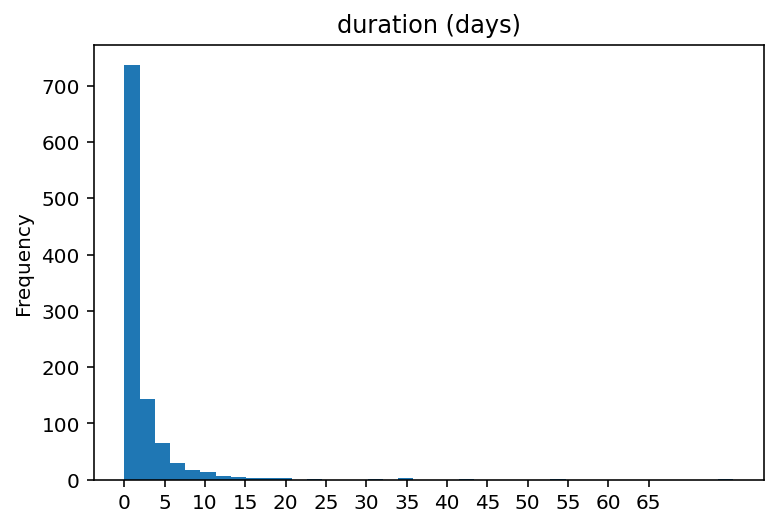

In [5]:
#The distribution of the outage.duration is fairly right-skewed
(sub['outage.duration']/(60*24)).plot(kind = 'hist', bins = 40, xticks = range(0,70,5), title = 'duration (days)');

In [6]:
#Encode the duration time with '<= 1 day', '<= 3 days but > 1 day', and 'above 3 days'
def encode_duration(x):
    duration_days = x/(60*24)
    if duration_days <= 1:
        return '<= 1 day'
    elif duration_days <= 3:
        return '<= 3 days but > 1 day'
    else:
        return 'above 3 days'

In [7]:
#The probability of outage duration fallen into these three ranges
days = sub['outage.duration']/(60*24)
(days < 1).mean(), ((days >= 1)*(days < 3)).mean(), (days >= 3).mean()

(0.6040856031128404, 0.21206225680933852, 0.18385214007782102)

In [8]:
#Encode the duration time with 'encode_duration' and drop the column 'outage.duration'
sub['duration.encoded'] = sub['outage.duration'].apply(encode_duration)
sub = sub.drop(columns = 'outage.duration')
sub.head()

,u.s._state,cause.category,outage.start.time,cause.category.detail,duration.encoded
0,Minnesota,intentional attack,18:38:00,vandalism,<= 1 day
1,Minnesota,severe weather,20:00:00,heavy wind,<= 3 days but > 1 day
2,Minnesota,severe weather,04:30:00,thunderstorm,<= 3 days but > 1 day
3,Minnesota,severe weather,15:00:00,winter storm,<= 3 days but > 1 day
4,Minnesota,severe weather,20:30:00,tornadoes,<= 3 days but > 1 day


In [9]:
#Prepare the dataframe used by the baseline model
#We want to use 'u.s._state' and 'cause.category' two features to make prediction
sub_base = sub.copy().drop(columns = ['outage.start.time', 'cause.category.detail'])
sub_base.head()

,u.s._state,cause.category,duration.encoded
0,Minnesota,intentional attack,<= 1 day
1,Minnesota,severe weather,<= 3 days but > 1 day
2,Minnesota,severe weather,<= 3 days but > 1 day
3,Minnesota,severe weather,<= 3 days but > 1 day
4,Minnesota,severe weather,<= 3 days but > 1 day


In [10]:
#Import temp_state.csv which contains the state name, the average temperature in winter by state in Celcius, 
#and the average temperature in summer by state in Celcius. We want to use these two features to help improve
#the accuracy in the final model
temp_df = pd.read_csv('temp_state.csv')
temp_df.head()

,u.s._state,winter_avg_temp,summer_avg_temp
0,Alabama,8.1,25.9
1,Alaska,-16.3,11.3
2,Arizona,6.4,25.6
3,Arkansas,5.3,26.0
4,California,7.9,23.0


In [11]:
#To improve our prediction, we want to include the outage.start.time column in the dataframe for the final model as well
#Merge temp_df to the final_sub to add two more features: 'winter_avg_temp' and 'summer_avg_temp' 
#in the final prediction model
sub_final = sub.copy()
sub_final = sub_final.merge(temp_df, left_on = 'u.s._state', right_on = 'u.s._state')
sub_final.head()

,u.s._state,cause.category,outage.start.time,cause.category.detail,duration.encoded,winter_avg_temp,summer_avg_temp
0,Minnesota,intentional attack,18:38:00,vandalism,<= 1 day,-10.9,19.3
1,Minnesota,severe weather,20:00:00,heavy wind,<= 3 days but > 1 day,-10.9,19.3
2,Minnesota,severe weather,04:30:00,thunderstorm,<= 3 days but > 1 day,-10.9,19.3
3,Minnesota,severe weather,15:00:00,winter storm,<= 3 days but > 1 day,-10.9,19.3
4,Minnesota,severe weather,20:30:00,tornadoes,<= 3 days but > 1 day,-10.9,19.3


### Baseline Model

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier

In [13]:
#Build the model by transforming 'u.s._state' and 'cause.category' columns using one hot encoder from sklearn
#Fit the data using DecisionTreeClassifier with max_depth = 5 and find the R-square of the prediction
prepro = ColumnTransformer(
    transformers = [('ohe', OneHotEncoder(handle_unknown='ignore'), ['u.s._state', 'cause.category'])],
    remainder = 'passthrough'
)
ppl_base = Pipeline(
    steps = [
        ('prepro', prepro),
        ('dtree', DecisionTreeClassifier(max_depth = 5))
    ]
)
ppl_base.fit(sub_base.drop(columns = 'duration.encoded'), sub_base['duration.encoded'])
ppl_base.score(sub_base.drop(columns = 'duration.encoded'), sub_base['duration.encoded'])

0.6682879377431906

In [14]:
#Dictionary of hyper parameter used to find the best fit
hypers = {
    'dtree__max_depth':[2,3,4,5,6,7,8,9,10,11,12,13,14,15]
}

In [15]:
#Apply GridSearchCV on the baseline model to find the best-fit hyperparameter
X_train, X_test, y_train, y_test = train_test_split(
    sub_base.drop(columns = 'duration.encoded'),
    sub['duration.encoded'],)
searcher = GridSearchCV(ppl_base, hypers, cv = 5)
searcher.fit(X_train, y_train)
searcher.best_params_, searcher.score(X_train, y_train), searcher.score(X_test, y_test)

({'dtree__max_depth': 14}, 0.7042801556420234, 0.6653696498054474)

### Final Model

In [16]:
#Helper function that converts time of a day to four periods of time
def descretize_startTime(time):
    #Morning 5 am to 12 pm (noon)
    #Afternoon 12 pm to 5 pm.
    #Evening 5 pm to 9 pm.
    #Night 9 pm to 4 am.
    if time.hour >= 5 and time.hour < 12:
        return 'Morning'
    elif time.hour >= 12 and time.hour < 17:
        return 'Afternoon'
    elif time.hour >= 17 and time.hour < 21:
        return 'Evening'
    else:
        return 'Night'

In [17]:
#Function that apply descretize_startTime on a series/dataframe and return a dataframe
def change_starttime(ser):
    df = pd.DataFrame(ser)
    return pd.DataFrame(df['outage.start.time'].apply(descretize_startTime))

#Pipeline that transform 'outage.start.time' feature using change_starttime function and OneHotEncoder
discretize_time = Pipeline([
        ('discretize_hour', FunctionTransformer(change_starttime)),
        ('one_hot_encoding', OneHotEncoder())
        ]
    )

In [18]:
#Function that converts summer temperature into boolean to define whether the summer is hot
def transform_hot(temp):
    df = pd.DataFrame(temp)
    def check_warm(x):
        if x >= 25:
            return True
        else:
            return False
    return pd.DataFrame(df['summer_avg_temp'].apply(check_warm))

#Pipeline that transform 'summer_avg_temp' feature using transform_hot function and OneHotEncoder
hot_changed = Pipeline([
        ('temp_to_hot', FunctionTransformer(transform_hot)),
        ('one_hot_encoding', OneHotEncoder())
        ]
    )

In [19]:
#Function that converts winter temperature into boolean to define whether the winter is cold
def transform_cold(temp):
    df = pd.DataFrame(temp)
    def check_cold(x):
        if x <= 0 :
            return True
        else:
            return False
    return pd.DataFrame(df['winter_avg_temp'].apply(check_cold))

#Pipeline that transform 'summer_avg_temp' feature using transform_cold function and OneHotEncoder
cold_changed = Pipeline([
        ('temp_to_cold', FunctionTransformer(transform_cold)),
        ('one_hot_encoding', OneHotEncoder())
        ]
    )

In [20]:
#Build the model by transforming 'u.s._state', 'cause.category', 
#and 'cause.category.detail' columns using one hot encoder from sklearn
#Also include the transformed columns 'outage.start.time', 'winter_avg_temp', and 'summer_avg_temp' 
#Fit the data using DecisionTreeRegressor with max_depth = 5 and find the R-square of the prediction
prepro = ColumnTransformer(
    transformers = [('ohe', OneHotEncoder(handle_unknown='ignore'), ['u.s._state', 'cause.category',
                                                                     'cause.category.detail']),
                    ('start_time_discretize', discretize_time, ['outage.start.time']),
                   ('cold_changed_prepro', cold_changed, ['winter_avg_temp']),
                   ('hot_changed_prepro', hot_changed, ['summer_avg_temp'])],
    remainder = 'passthrough'
)
ppl_improve = Pipeline(
    steps = [
        ('prepro', prepro),
        ('dtree2', DecisionTreeClassifier(max_depth = 5))
        
    ]
)

ppl_improve.fit(sub_final.drop(columns = 'duration.encoded'), sub_final['duration.encoded'])
ppl_improve.score(sub_final.drop(columns = 'duration.encoded'), sub_final['duration.encoded'])

0.7062256809338522

In [21]:
#Dictionary of hyper parameter used to find the best fit
hypers2 = {
    'dtree2__max_depth':[2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    'dtree2__splitter': ['best', 'random'],
}

In [25]:
#Apply GridSearchCV on the baseline model to find the best-fit hyperparameter
X2_train, X2_test, y2_train, y2_test = train_test_split(
    sub_final.drop(columns = 'duration.encoded'), sub_final['duration.encoded'])
searcher = GridSearchCV(ppl_improve, hypers2, cv = 5)
searcher.fit(X2_train, y2_train)
searcher.best_params_, searcher.score(X2_train, y2_train), searcher.score(X2_test, y2_test)

({'dtree2__max_depth': 12, 'dtree2__splitter': 'random'},
 0.814526588845655,
 0.7042801556420234)

### Fairness Analysis

In [86]:
pred_correct = searcher.predict(X2_test) == y2_test
#check the accuracy of each prediction in the test dataset

In [120]:
fair_df = pd.DataFrame(X2_test[['outage.start.time']])
fair_df['predict'] = pred_correct
fair_df = fair_df.reset_index(drop = True)
#construct data for permutation test with two columns: start time in the day, if accurate
fair_df.head()

,outage.start.time,predict
0,18:00:00,True
1,17:00:00,False
2,15:54:00,False
3,08:30:00,True
4,21:31:00,False


In [121]:
fair_df['start.afternoon'] = fair_df['outage.start.time'].apply(
    lambda x: str(x)).str[0:2].apply(lambda x: int(x) >= 12)
#binary-encode each observation: true if happen in the P.M false if in A.M
fair_df = fair_df.drop(columns = ['outage.start.time'])
fair_df.head()

,predict,start.afternoon
0,True,True
1,False,True
2,False,True
3,True,False
4,False,True


In [122]:
gp = fair_df.groupby('start.afternoon').agg('mean')
obs = gp['predict'][False] - gp['predict'][True]
obs
#observed accuracy diff: Accuracy(A.M) - Accuracy(P.M)

0.054501216545012166

In [117]:
sim = []
for _ in range(1000):
    copy = fair_df[['predict']] 
    copy['start.afternoon'] = np.random.permutation(fair_df['start.afternoon'].values)
    gp = copy.groupby('start.afternoon').mean()
    s = gp['predict'][False] - gp['predict'][True]
    sim.append(s)
#1000 permutation
(sim > obs).mean()
#calculate p-value

0.145